# iSnobal output evaluation
*J. Michelle Hu  
University of Utah  
June 2024*  
---

In [1]:
import os
import sys
import xarray as xr
import numpy as np

from pathlib import PurePath
import pandas as pd
import hvplot.xarray
import rioxarray as riox
import matplotlib.pyplot as plt

sys.path.append('/uufs/chpc.utah.edu/common/home/u6058223/git_dirs/env/')
import helpers as h

sys.path.append('/uufs/chpc.utah.edu/common/home/u6058223/git_dirs/ucrb-isnobal/scripts/')
import processing as proc

/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3/envs/work/lib/python3.12/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
# Set environmental variable for PROJ to directory where you can find proj.db
os.environ['PROJ']='/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3/pkgs/proj-9.3.1-h1d62c97_0/share/proj'
os.environ['PROJLIB']='/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3/pkgs/proj-9.3.1-h1d62c97_0/share/proj'

## Directory

In [4]:
basin = 'blue'

In [5]:
workdir = '/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/model_runs/'
basindir = h.fn_list(workdir, f'*{basin}*')[0]

# currently for one WY (only one per basin as of 20240618), will need to add more for WYs in the future
days = h.fn_list(basindir, "*/*/run*/")

snotel_dir = '/uufs/chpc.utah.edu/common/home/skiles-group3/SNOTEL'

In [6]:
# Extract water year
WY = int(days[0].split('wy')[1].split('/')[0])

# Comparisons for Blue River

In [7]:
# Extract snotel point coords and plot
sitenums = [485, 531, 415, 505] # Fremont Pass, Hoosier Pass, Copper Mountain, Grizzly Peak

allsites_fn = h.fn_list(snotel_dir, '*active*csv')[0]
sites_df = pd.read_csv(allsites_fn, index_col=0)
sites_df.head()

,ntwk,state,site_name,ts,start,lat,lon,elev,county,huc,site_num
0,SNTL,AK,Alexander Lake (1267),NaN,2014-August,61.75,-150.89,160,Matanuska-susitna,Upper Alexander Creek (190205051106),1267
1,SNTL,AK,American Creek (1189),NaN,2011-August,64.79,-141.23,1050,Southeast Fairbanks,American Creek (190705050504),1189
2,SNTL,AK,Anchor River Divide (1062),NaN,1980-October,59.86,-151.32,1653,Kenai Peninsula,Headwaters Anchor River (190203010701),1062
3,SNTL,AK,Anchorage Hillside (1070),NaN,2004-October,61.11,-149.67,2080,Anchorage,South Fork Campbell Creek (190204010601),1070
4,SNTL,AK,Aniak (2065),NaN,2002-July,61.58,-159.58,80,Bethel,Aniak Slough-Kuskokwim River (190305020504),2065


In [8]:
# Extract the lats and lons based on these site numbers
snotellats = []
snotellons = []

for sitenum in sitenums:
    print(sitenum)
    this_site = sites_df[sites_df['site_num']==sitenum]
    lat, lon = this_site['lat'].values[0], this_site['lon'].values[0]
    snotellats.append(lat)
    snotellons.append(lon)

snotellats, snotellons

485
531
415
505


([39.38, 39.36, 39.49, 39.65], [-106.2, -106.06, -106.17, -105.87])

In [9]:
# Convert to UTM EPSG 32613

import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import pyproj

pyproj.datadir.set_data_dir('/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3/pkgs/proj-9.3.1-h1d62c97_0/share/proj')

# Create a Geoseries based off of a list of a Shapely point using the lat and lon from the SNOTEL site
s = gpd.GeoSeries([Point(lon, lat) for lon, lat in zip(snotellons, snotellats)])

# Turn this into a geodataframe and specify the geom as the geoseries of the SNOTEL point
gdf = gpd.GeoDataFrame(geometry=s)

# Set the CRS inplace
gdf.set_crs('epsg:4326', inplace=True)

# Convert snotel coords' lat lon to UTM
gdf = gdf.to_crs('epsg:32613')
gdf

,geometry
0,POINT (396646.502 4359633.712)
1,POINT (408678.649 4357263.171)
2,POINT (399388.787 4371808.031)
3,POINT (425358.761 4389273.436)


## TODO - add day selection based on date from days idx or just locate rundatedir from date precisely

In [10]:
# # Extract data value from this point based on nearest neighbor lookup (inexact)
# # Coords must be bracketed
# # 24 hours
# idx = 200
# fn = h.fn_list(days[idx], "snow.nc")[0]
# ds = xr.open_dataset(fn)
# ds['thickness'].sel(x=list(gdf.geometry.x.values), y=list(gdf.geometry.y.values), method='nearest').values

In [11]:
%%time
# Ok, now that we have the proper geometry for the SNOTEL site in UTM 13N coords
# run through all the snow.nc files in the working directory 
# and extract the snow depth from each of these files
depths = []
snow_fns = h.fn_list(PurePath(days[0]).parents[0].as_posix(), '*/snow.nc')

for sd_fn in snow_fns:
    ds = xr.open_dataset(sd_fn)
    # Extract data value from this point based on nearest neighbor lookup (inexact)
    # Coords must be bracketed
    snowdepth = ds['thickness'].sel(x=list(gdf.geometry.x.values), y=list(gdf.geometry.y.values), method='nearest')
    depths.append(snowdepth)
    del ds, snowdepth

CPU times: user 10.4 s, sys: 4.52 s, total: 14.9 s
Wall time: 16.6 s


### Concatenate the list of data arrays into a single dataarray based on time dimension

In [12]:
%%time
depth_ts = xr.concat(depths, dim='time')
print(depth_ts.x.values)
print(depth_ts.y.values)

[396687.94 408687.94 399387.94 425387.94]
[4359584. 4357284. 4371784. 4389284.]
CPU times: user 7.76 s, sys: 4.54 s, total: 12.3 s
Wall time: 14 s


### Extract into individual time series

In [13]:
%%time
site_ts_list = []
for jdx, sitenum in enumerate(sitenums):
    print(jdx)
    site_ts = depth_ts[:, jdx, jdx]
    site_ts_list.append(site_ts)

0
1
2
3
CPU times: user 2.8 ms, sys: 0 ns, total: 2.8 ms
Wall time: 2.77 ms


In [14]:
# get the site names
sitenames = []
for sitenum in sitenums:
    sitename = sites_df[sites_df['site_num']==sitenum]['site_name'].values[0]
    sitenames.append(sitename)
sitenames

['Fremont Pass (485)',
 'Hoosier Pass (531)',
 'Copper Mountain (415)',
 'Grizzly Peak (505)']

In [15]:
# Extract the times from the depths list
dt_list = [depth['time'].values[0] for depth in depths]

In [16]:
# Put the extracted depths into a dataframe
depth_ts_df = pd.DataFrame(data=np.array(site_ts_list).T, columns=sitenames, index=dt_list)
depth_ts_df

,Fremont Pass (485),Hoosier Pass (531),Copper Mountain (415),Grizzly Peak (505)
2018-10-01 22:00:00,0.0,0.0,0.0,0.0
2018-10-02 22:00:00,0.0,0.0,0.0,0.0
2018-10-03 22:00:00,0.0,0.0,0.0,0.0
2018-10-04 22:00:00,0.0,0.0,0.0,0.0
2018-10-05 22:00:00,0.0,0.0,0.0,0.0
...,...,...,...,...
2019-09-26 22:00:00,0.0,0.0,0.0,0.0
2019-09-27 22:00:00,0.0,0.0,0.0,0.0
2019-09-28 22:00:00,0.0,0.0,0.0,0.0
2019-09-29 22:00:00,0.0,0.0,0.0,0.0


### Now plot the SNOTEL snow depths

In [17]:
linestyle = '-' #':'
linewidth = 1
marker = None
color = 'k'
snotelcolors = ['dodgerblue', 'gray']

Fremont Pass (485)
Hoosier Pass (531)
Copper Mountain (415)
Grizzly Peak (505)


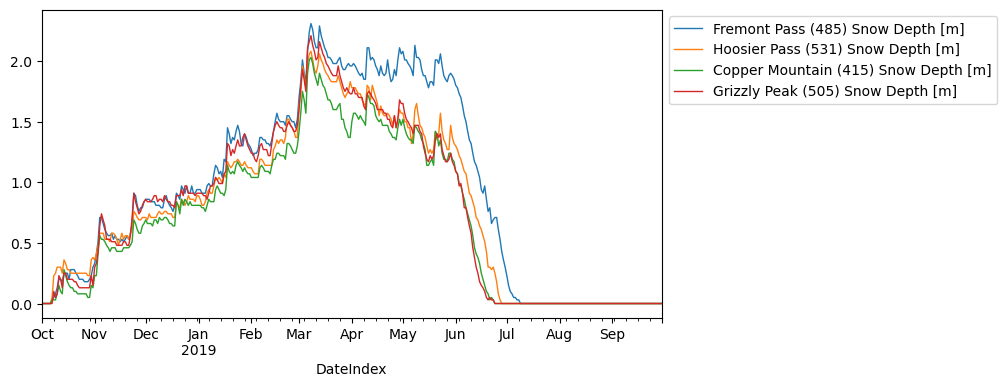

In [18]:
# Grab PoR csv and read in the proper WY
figsize = (8, 4)
fig, ax = plt.subplots(1, 1, figsize=figsize)

for sitename in sitenames:
    print(sitename)
    sitenum = sitename.split('(')[1].split(')')[0]
    # print(sitenum)
    
    # Locate period or record csv for this site
    snotelfn = h.fn_list(snotel_dir, f'*{sitenum}*csv')[0]
    
    df = pd.read_csv(snotelfn, skiprows=63, usecols=list(np.arange(0, 7)), parse_dates=["Date"])
    
    # Copy date to new date indexing column
    df['DateIndex'] = df['Date']

    # reset index as Date
    df = df.set_index('DateIndex')

    # Clip to this water year
    snotel_df = df[(df['Date']>=f'{int(WY) - 1}-10-01') & (df['Date']<f'{WY}-10-01')]
    
    # Plot WY time series of snow depth
    (snotel_df[f'{sitename} Snow Depth (cm) End of Day Values']/100).plot(ax=ax, 
                                                                    label=f'{sitename} Snow Depth [m]', 
                                                                    linestyle=linestyle, 
                                                                    linewidth=linewidth, 
                                                                    # color=snotelcolors[0], 
                                                                    marker=marker)
plt.legend(bbox_to_anchor=(1,1))

### And plot alongside model snow depth

Fremont Pass (485)
Hoosier Pass (531)
Copper Mountain (415)
Grizzly Peak (505)


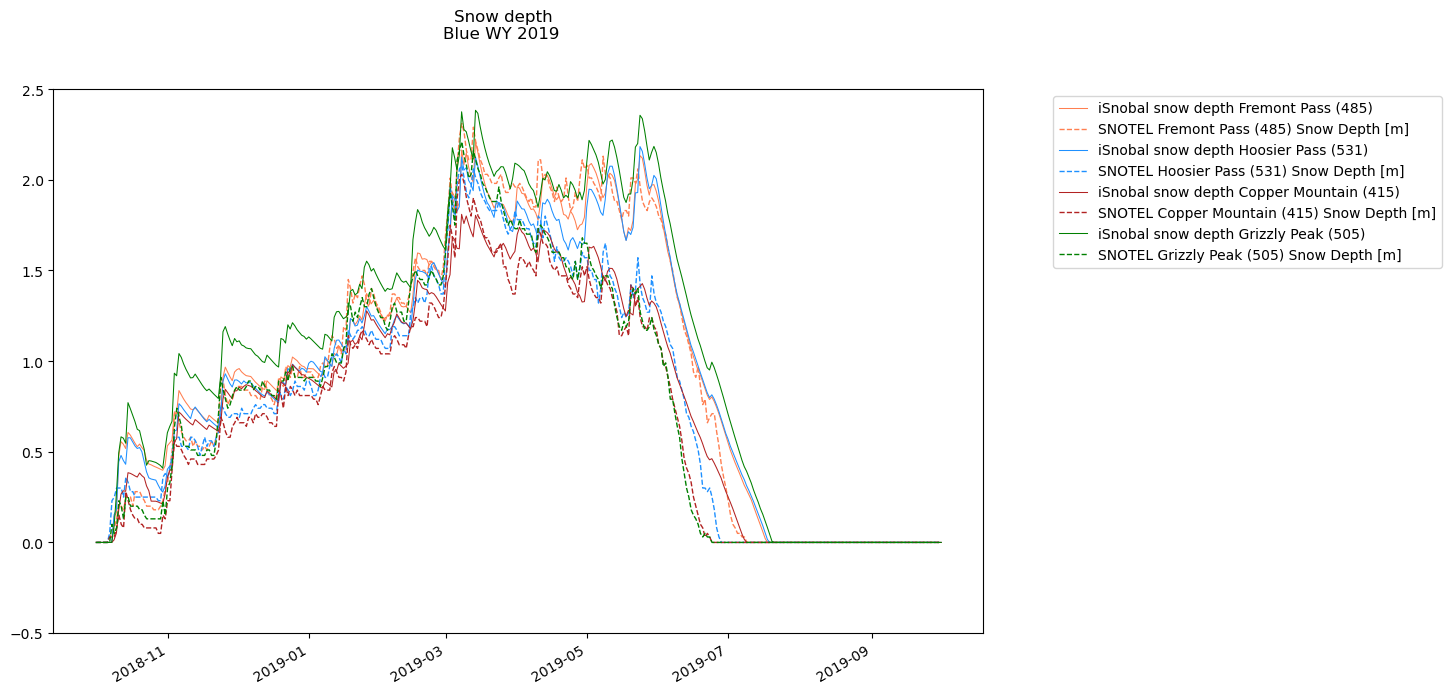

In [19]:
fig, ax = plt.subplots(1, figsize=(12, 8))
ylims = (-0.5, 2.5)

colors = ['coral', 'dodgerblue', 'firebrick', 'green']
linestyles = ['-', '--', ]

for jdx, (site, sitename) in enumerate(zip(depth_ts_df, sitenames)):
    print(site)
    depth_ts_df[site].plot(label=f'iSnobal snow depth {site}', ax=ax, linestyle=linestyles[0], color=colors[jdx], linewidth=0.75)
    # print(sitename)
    sitenum = sitename.split('(')[1].split(')')[0]
    # Locate period or record csv for this site
    snotelfn = h.fn_list(snotel_dir, f'*{sitenum}*csv')[0]
    
    df = pd.read_csv(snotelfn, skiprows=63, usecols=list(np.arange(0, 7)), parse_dates=["Date"])
    
    # Copy date to new date indexing column
    df['DateIndex'] = df['Date']

    # reset index as Date
    df = df.set_index('DateIndex')

    # Clip to this water year
    snotel_df = df[(df['Date']>=f'{int(WY) - 1}-10-01') & (df['Date']<f'{WY}-10-01')]
    
    # Plot WY time series of snow depth
    (snotel_df[f'{sitename} Snow Depth (cm) End of Day Values']/100).plot(ax=ax, 
                                                                    label=f'SNOTEL {sitename} Snow Depth [m]', 
                                                                    linestyle=linestyles[1], 
                                                                    linewidth=linewidth, 
                                                                    color=colors[jdx], 
                                                                    marker=marker)
    
plt.xlabel('')
plt.gca().set_ylim(ylims)
plt.legend(loc='upper right', bbox_to_anchor=(1.5,1), alignment='center')
plt.suptitle(f'Snow depth\n{basin.title()} WY {WY} ');
# plt.tight_layout()

## Plot by individual SNOTEL site

Fremont Pass (485)
Hoosier Pass (531)
Copper Mountain (415)
Grizzly Peak (505)


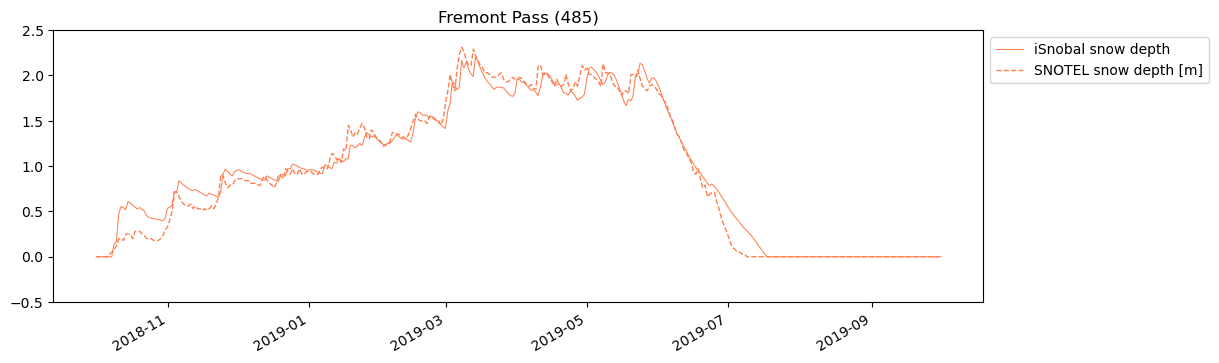

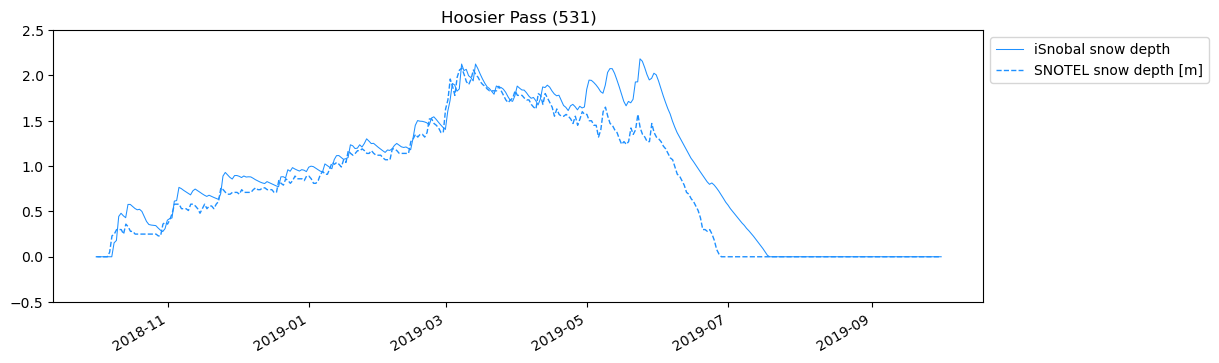

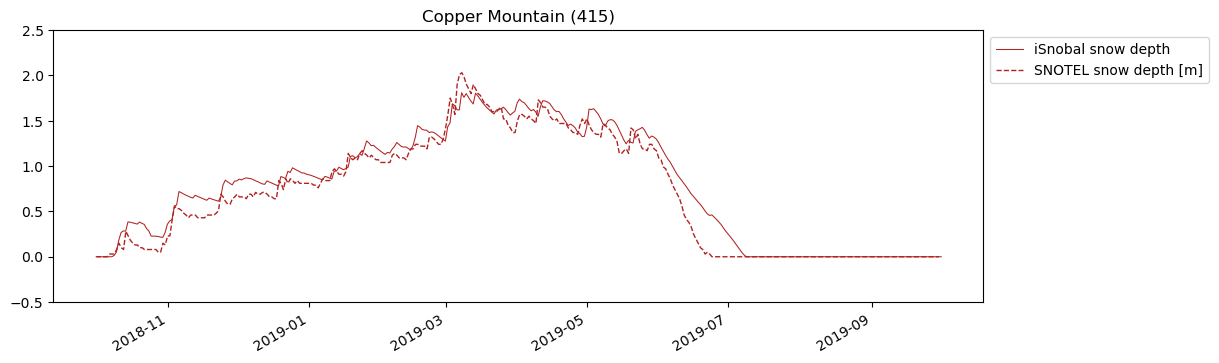

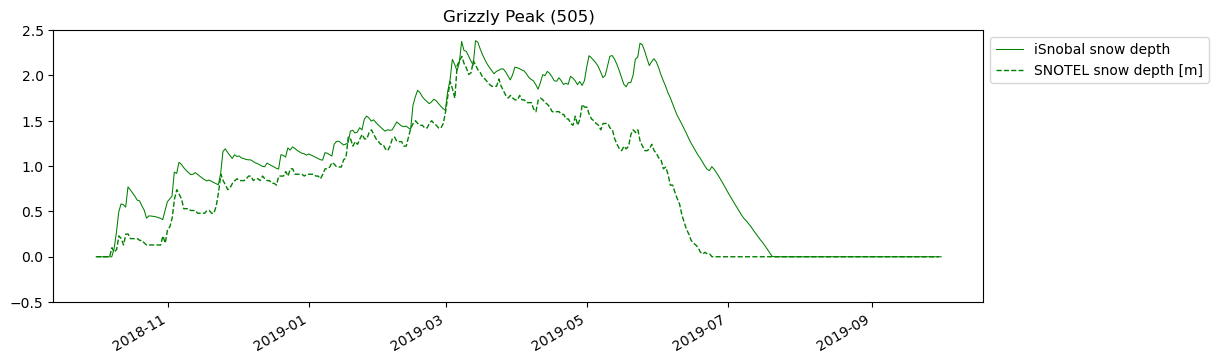

In [20]:
for jdx, (site, sitename) in enumerate(zip(depth_ts_df, sitenames)):
    fig, ax = plt.subplots(1, figsize=(12, 4))
    
    print(site)
    depth_ts_df[site].plot(label=f'iSnobal snow depth', ax=ax, linestyle=linestyles[0], color=colors[jdx], linewidth=0.75)
    # print(sitename)
    sitenum = sitename.split('(')[1].split(')')[0]
    # Locate period or record csv for this site
    snotelfn = h.fn_list(snotel_dir, f'*{sitenum}*csv')[0]
    
    df = pd.read_csv(snotelfn, skiprows=63, usecols=list(np.arange(0, 7)), parse_dates=["Date"])
    
    # Copy date to new date indexing column
    df['DateIndex'] = df['Date']

    # reset index as Date
    df = df.set_index('DateIndex')

    # Clip to this water year
    snotel_df = df[(df['Date']>=f'{int(WY) - 1}-10-01') & (df['Date']<f'{WY}-10-01')]
    
    
    
    # Plot WY time series of snow depth
    (snotel_df[f'{sitename} Snow Depth (cm) End of Day Values']/100).plot(ax=ax, 
                                                                    label=f'SNOTEL snow depth [m]', 
                                                                    linestyle=linestyles[1], 
                                                                    linewidth=linewidth, 
                                                                    color=colors[jdx], 
                                                                    marker=marker)
    plt.title(f'{sitename}')
    plt.xlabel('')
    plt.gca().set_ylim(ylims)
    plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1), alignment='center')
# plt.suptitle(f'Snow depth\n{basin.title()} WY {WY} ');

### Find snow disappearance date

<Axes: xlabel='DateIndex'>

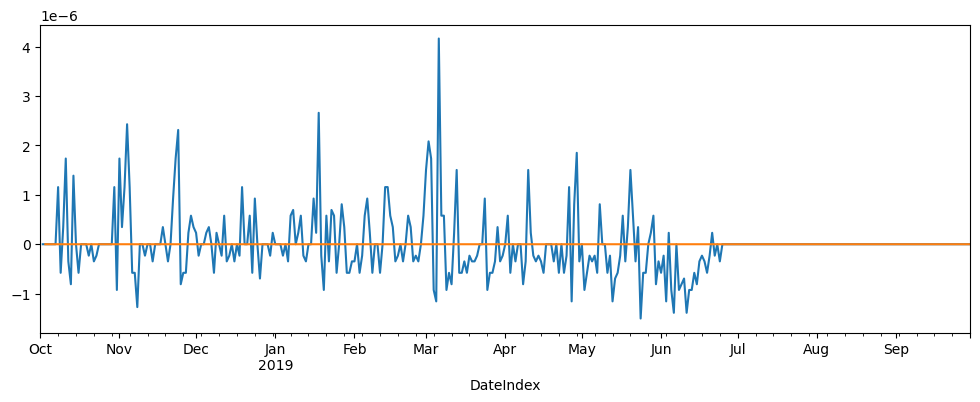

In [21]:
# Plot the derivative
snotel_sd = snotel_df[f'{sitename} Snow Depth (cm) End of Day Values']/100
snotel_sd_firstderiv = snotel_sd.diff() / snotel_sd.index.to_series().diff().dt.total_seconds()
snotel_sd_firstderiv.plot(figsize=(12, 4))

# Plot the second derivative
snotel_sd_secondderiv = snotel_sd_firstderiv.diff() / snotel_sd_firstderiv.index.to_series().diff().dt.total_seconds()
snotel_sd_secondderiv.plot(figsize=(12, 4))

<Axes: xlabel='DateIndex'>

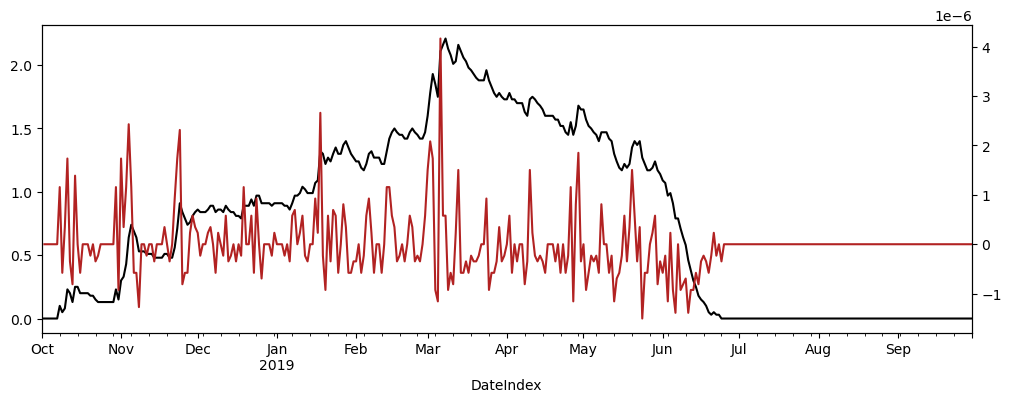

In [22]:
fig, ax1 = plt.subplots(figsize=(12, 4))
ax2 = ax1.twinx()

(snotel_df[f'{sitename} Snow Depth (cm) End of Day Values']/100).plot(ax=ax1, color='k')

# Plot the derivative
# From https://stackoverflow.com/questions/41780489/python-pandas-how-to-calculate-derivative-gradient
snotel_sd_firstderiv = snotel_sd.diff() / snotel_sd.index.to_series().diff().dt.total_seconds()
snotel_sd_firstderiv.plot(ax=ax2, color='firebrick')

# # Plot the second derivative
# snotel_sd_secondderiv = snotel_sd_firstderiv.diff() / snotel_sd_firstderiv.index.to_series().diff().dt.total_seconds()
# snotel_sd_secondderiv.plot(ax=ax2, color='orange')

In [24]:
sdd, grad = proc.calc_sdd(snotel_sd, verbose=True)

Snow all gone date 2019-06-24
Derivative: -3.472222222222222e-07 m
Snow depth: 0.0 m


### Determine melt out date difference

Fremont Pass (485)
Hoosier Pass (531)
Copper Mountain (415)
Grizzly Peak (505)


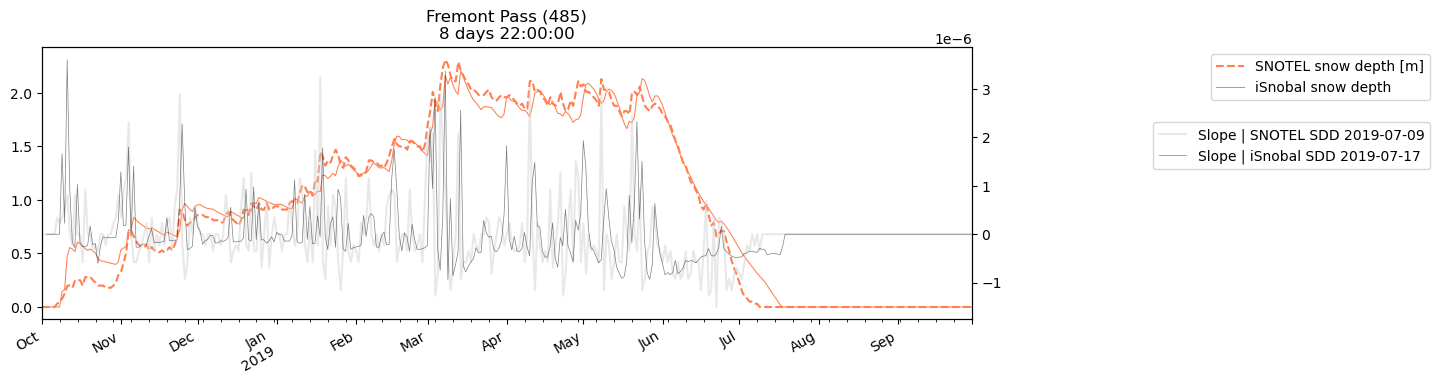

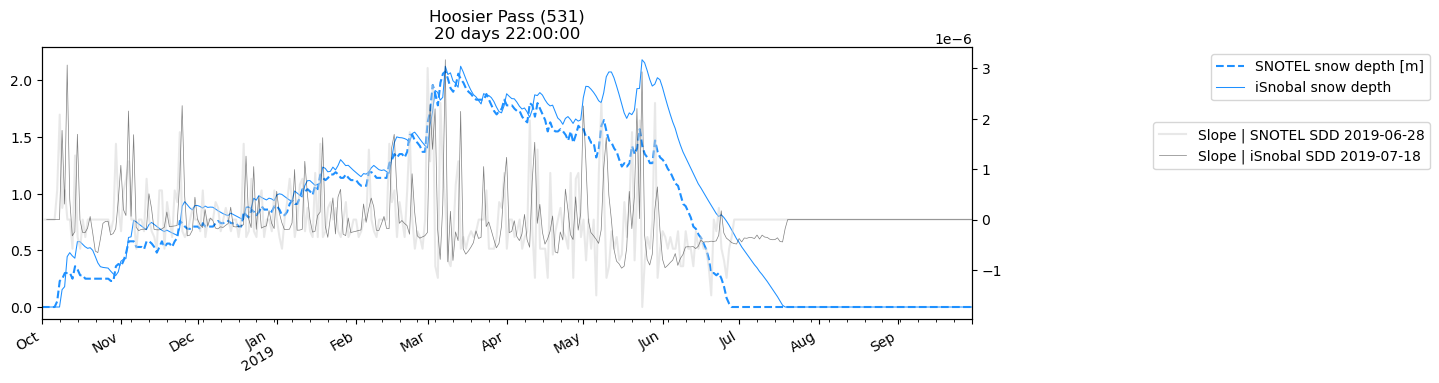

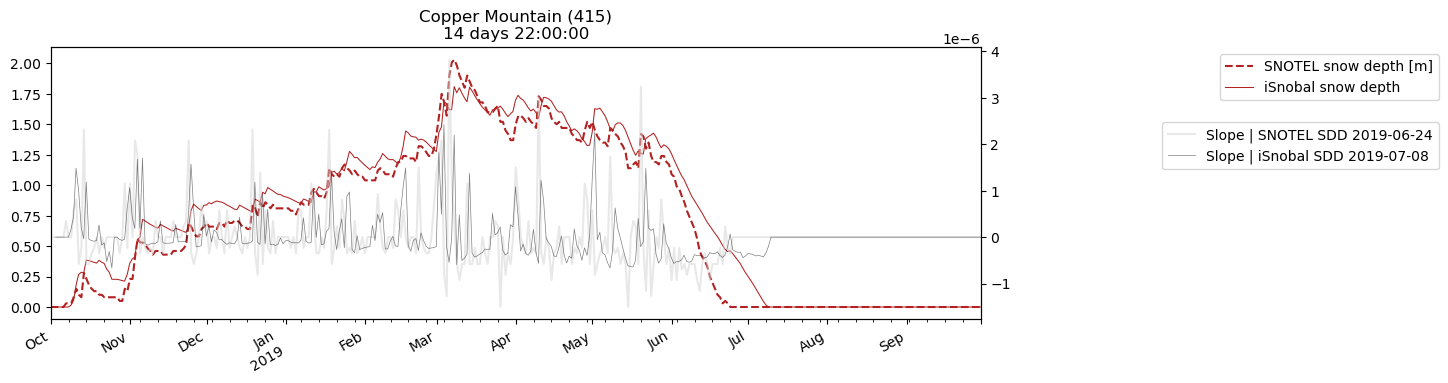

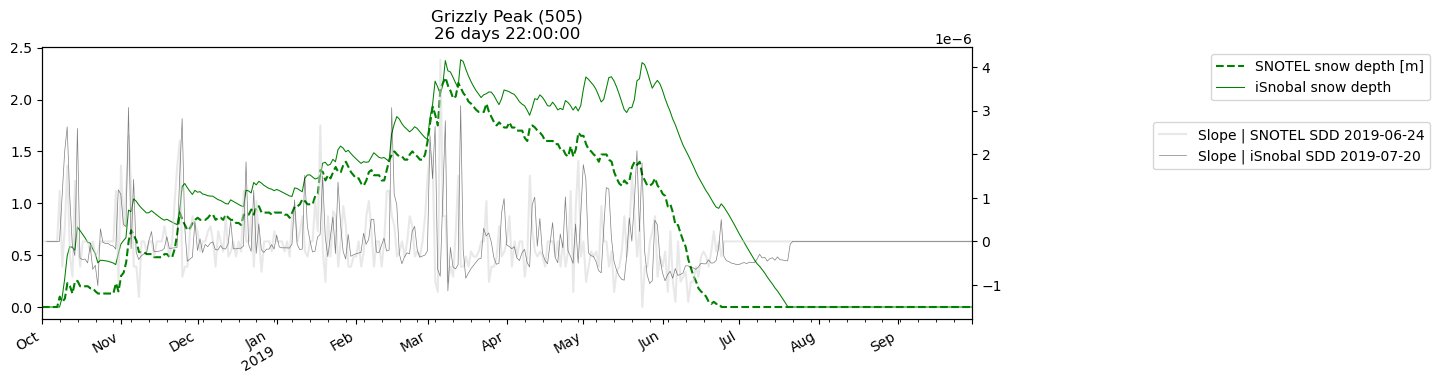

In [25]:
linewidth = 1.5
alpha = 0.5

for jdx, (site, sitename) in enumerate(zip(depth_ts_df, sitenames)):
    print(site)
    model_sd = depth_ts_df[site]

    # print(sitename)
    sitenum = sitename.split('(')[1].split(')')[0]
    
    # Locate period or record csv for this site
    snotelfn = h.fn_list(snotel_dir, f'*{sitenum}*csv')[0]
    
    df = pd.read_csv(snotelfn, skiprows=63, usecols=list(np.arange(0, 7)), parse_dates=["Date"])
    
    # Copy date to new date indexing column
    df['DateIndex'] = df['Date']

    # reset index as Date
    df = df.set_index('DateIndex')

    # Clip to this water year
    snotel_df = df[(df['Date']>=f'{int(WY) - 1}-10-01') & (df['Date']<f'{WY}-10-01')]
    snotel_sd = snotel_df[f'{sitename} Snow Depth (cm) End of Day Values']/100
    # # Plot WY time series of snow depth
    # (snotel_df[f'{sitename} Snow Depth (cm) End of Day Values']/100).plot()    
    
    fig, ax1 = plt.subplots(figsize=(12, 4))
    ax2 = ax1.twinx()
    snotel_sd.plot(ax=ax1,
                   label=f'SNOTEL snow depth [m]',
                   linestyle=linestyles[1],
                   linewidth=linewidth,
                   color=colors[jdx],
                   marker=marker,
                   # color='k', label='Snow Depth'
                  )

    # Calculate and plot the derivative
    snotel_sdd, snotel_grad = proc.calc_sdd(snotel_sd)
    snotel_grad.plot(ax=ax2, color='lightgray', alpha=alpha, linewidth=linewidth, label=f'Slope | SNOTEL SDD {snotel_sdd.strftime('%Y-%m-%d')}')
    
    # Plot the modeled snow depth
    model_sd.plot(label=f'iSnobal snow depth', ax=ax1, linestyle=linestyles[0], color=colors[jdx], linewidth=0.75)
    
    # Calculate and plot the derivative
    sdd, grad = proc.calc_sdd(model_sd)
    grad.plot(ax=ax2, color='k', linewidth=0.5, alpha=alpha, label=f'Slope | iSnobal SDD {sdd.strftime('%Y-%m-%d')}')

    # Calculate the difference in meltout dates
    meltout_diff = sdd - snotel_sdd
    
    plt.title(f'{sitename}\n{meltout_diff}')
    ax1.set_xlabel('')
    ax2.set_xlabel('')
    ax1.legend(loc='upper right', bbox_to_anchor=(1.5, 1), alignment='center')
    ax2.legend(loc='upper right', bbox_to_anchor=(1.5, 0.75), alignment='center')

#### Misc. Note: dates of first derivatives which are positive should more or less match with precip timing

## ASO snow depth

In [26]:
aso_dir = '/uufs/chpc.utah.edu/common/home/skiles-group3/ASO'

#### Plot a single day from Colorado ERW
Note that basin naming is not consistent across years  
Add handling to merge snow depth and SWE variables 

In [27]:
state = 'CO'
# basin = 'Blue' # more recent collections
basin = 'USCOBR' # older NSIDC collections 

In [55]:
# Water year collections should all be post January so this should work
depth_fns = h.fn_list(aso_dir, f'{state}/*{basin}*{WY}*tif')
# depth_fns = h.fn_list(aso_dir, f'{state}/*{basin}*/*snowdepth*tif')
# swe_fns = h.fn_list(aso_dir, f'{state}/*{basin}*/*swe*tif')
print(depth_fns)

['/uufs/chpc.utah.edu/common/home/skiles-group3/ASO/CO/ASO_50M_SD_USCOBR_20190419.tif', '/uufs/chpc.utah.edu/common/home/skiles-group3/ASO/CO/ASO_50M_SD_USCOBR_20190624.tif']


#### >> Consider merging depth and swe arrays later on as in SWANN?

In [76]:
# Load depth arrays and squeeze out single dimensions
depth_list = [np.squeeze(xr.open_dataset(fn)) for fn in depth_fns]

# Rename band_data to descriptive snow_depth
depth_list = [ds.rename_vars({'band_data': 'snow_depth'}) for ds in depth_list]

# # Load swe arrays and squeeze out single dimensions
# swe_list = [np.squeeze(xr.open_dataset(fn)) for fn in swe_fns]

# # Rename band_data to descriptive swe
# swe_list = [ds.rename_vars({'band_data': 'swe'}) for ds in swe_list]

#### Deal with adding time input for ASO data

In [77]:
inputvar = '.'
depth_list = [proc.assign_dt(ds, proc.extract_dt(fn, inputvar=inputvar)) for ds, fn in zip(depth_list, depth_fns)]
# depth_list = [assign_dt(ds, extract_dt(fn)) for ds, fn in zip(depth_list, depth_fns)]
# swe_list = [assign_dt(ds, extract_dt(fn, inputvar='_swe')) for ds, fn in zip(swe_list, swe_fns)]

In [78]:
# Get dates, could easily just pull from filenames, but this is fine
date_list = [proc.extract_dt(fn, inputvar=inputvar)[0] for fn in depth_fns]
date_list = [f.strftime('%Y%m%d') for f in date_list]
date_list

['20190419', '20190624']

In [79]:
# h.plot_one(np.squeeze(depth_list[0]['snow_depth']), figsize=(6,4), vmin=0, vmax=3)

In [80]:
# %%time
# # This approach uses the bottom plotting mechanism
# depth_list = xr.concat(depth_list, dim='time')
# swe_list = xr.concat(swe_list, dim='time')

In [81]:
# depth_list[0].hvplot(cmap="fire", invert=True, aspect='equal', clim=(0, 4))

In [82]:
depth_list[0].time

<xarray.DataArray 'time' (time: 1)> Size: 8B
array(['2019-04-19T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time         (time) datetime64[ns] 8B 2019-04-19
    band         int64 8B 1
    spatial_ref  int64 8B ...

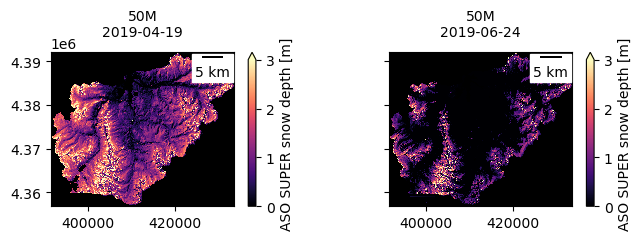

In [83]:
cmap = 'magma'
vmin, vmax = 0, 3
fig, ax = plt.subplots(1, len(depth_list), figsize=(4*len(depth_list),len(depth_list)), sharex=True, sharey=True)

for jdx, arr in enumerate(depth_list):
    thisax = ax.flatten()[jdx]
    # format date for title string
    ts = pd.to_datetime(str(arr['snow_depth'][0].time.values)) 
    d = ts.strftime('%Y-%m-%d')
    
    h.plot_one(arr=arr['snow_depth'][0], 
               specify_ax=(fig, thisax), 
               turnofflabels=True, 
               title=f'{PurePath(depth_fns[jdx]).name.split("_")[1]}\n{d}',
               # title=f'{PurePath(depth_fns[jdx]).name.split("_snowdepth_")[0]}\n_snowdepth_\n{PurePath(depth_fns[jdx]).name.split("_snowdepth_")[1]}', 
               # title=f'{PurePath(depth_fns[jdx]).name}', 
               vmin=vmin, 
               vmax=vmax, 
               cbaron=True,
               setfc='k',
               cmap=cmap
              )

## TODO: based on input remote sensing snow depth product date, pull corresponding iSnobal snow depth output

### iSnobal basin snow depth

In [84]:
date_list

['20190419', '20190624']

In [95]:
rundir = PurePath(days[0]).parents[0].as_posix()

ERROR 1: PROJ: proj_create_from_database: /uufs/chpc.utah.edu/sys/spack/linux-rocky8-nehalem/gcc-8.5.0/proj-8.1.0-usmhdefwvs6hvlo55oavx2t5x6xfarjz/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
ERROR 1: PROJ: proj_create_from_database: /uufs/chpc.utah.edu/sys/spack/linux-rocky8-nehalem/gcc-8.5.0/proj-8.1.0-usmhdefwvs6hvlo55oavx2t5x6xfarjz/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


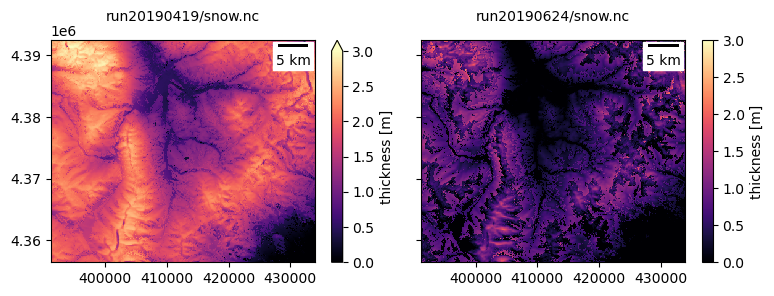

In [120]:
model_sd_arrs = []

fig, ax = plt.subplots(1, 2, figsize=(8, 3), sharex=True, sharey=True)

for jdx, dt in enumerate(date_list):
    fn = h.fn_list(rundir, f'run{dt}/snow.nc')[0]    
    ds = xr.open_dataset(fn)
    arr = np.squeeze(ds['thickness'])
    arr.rio.write_crs('EPSG:32613', inplace=True)
    
    title = fn.split(f'{rundir}/')[1]
    thisax = ax.flatten()[jdx]
    h.plot_one(arr, specify_ax=(fig, thisax), cmap='magma', title=title, turnofflabels=True, vmin=vmin, vmax=vmax)
    plt.tight_layout()
    
    model_sd_arrs.append(arr)

## Snow depth difference plot and histogram

CPU times: user 1.29 s, sys: 16.7 ms, total: 1.31 s
Wall time: 1.34 s


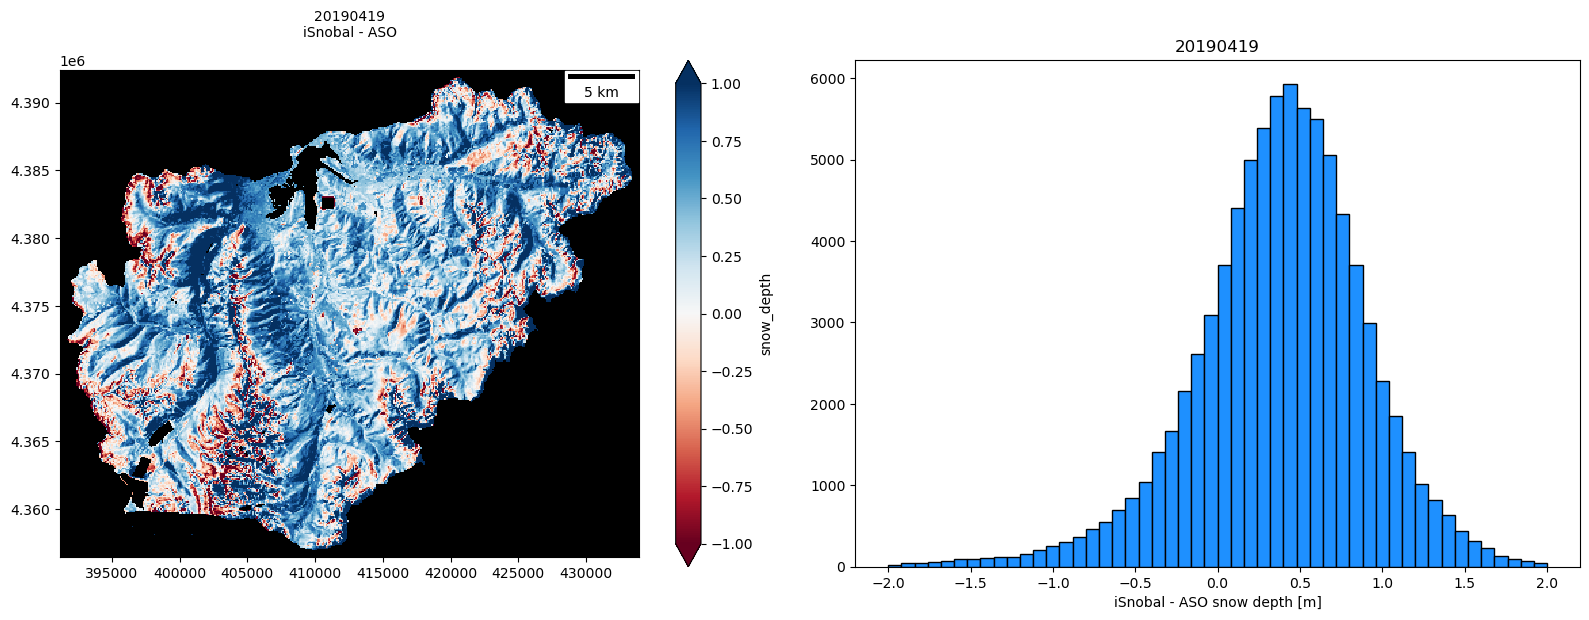

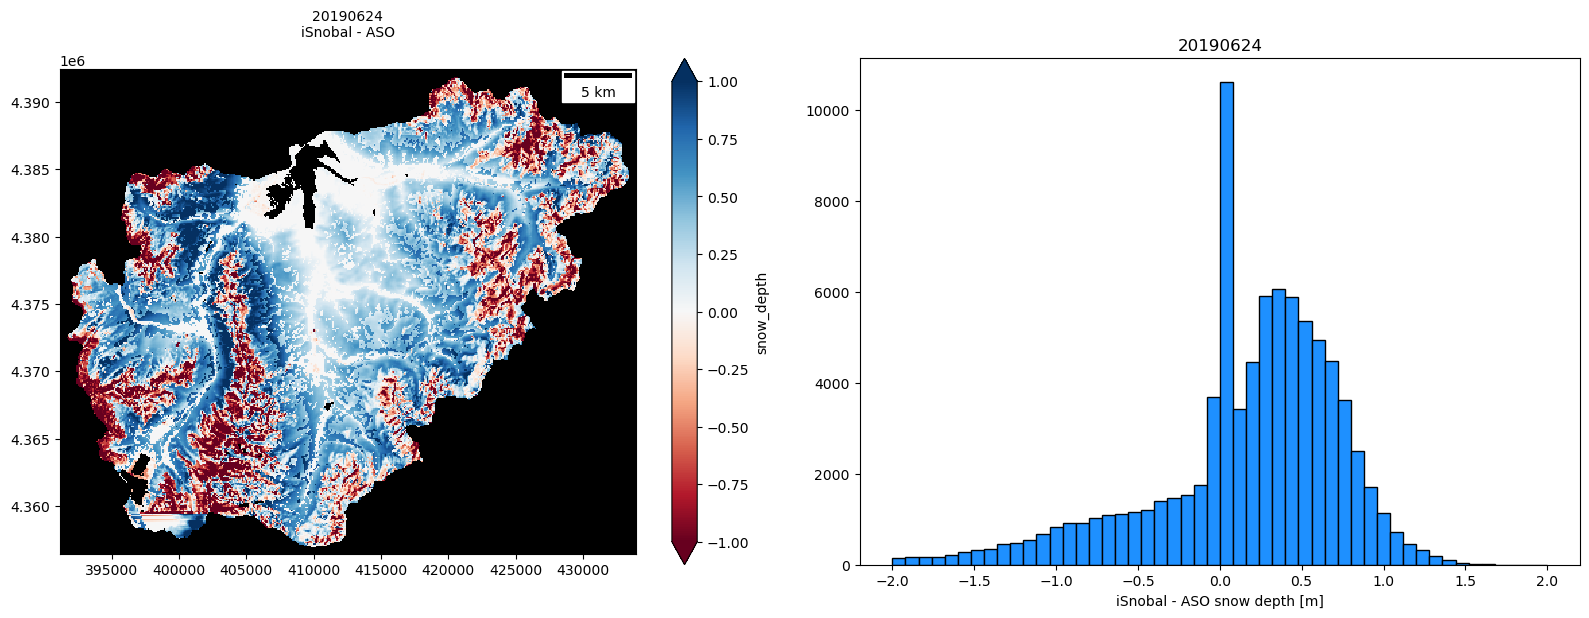

In [114]:
%%time
from rasterio.enums import Resampling

lims = 1
aso_sd_reprojlist = []

for dt, model_sd, aso_sd in zip(date_list, model_sd_arrs, depth_list):
    aso_sd_reproj = aso_sd.rio.reproject_match(match_data_array=model_sd, resampling=Resampling.cubic)
    aso_sd_reprojlist.append(aso_sd_reproj)
    
    fig, axa = plt.subplots(1, 2, figsize=(16 ,6))
    ax1 = axa.flatten()[0]
    h.plot_one((model_sd - np.squeeze(aso_sd_reproj))['snow_depth'], 
               specify_ax=(fig, ax1), 
               cmap='RdBu', 
               title=f'{dt}\niSnobal - ASO', 
               turnofflabels=True, 
               vmin=-lims, 
               vmax=lims,
               setfc='k'
              )
    
    # Plot histogram of differences
    ax2 = axa.flatten()[1]
    h.plot_hist((model_sd - np.squeeze(aso_sd_reproj))['snow_depth'], specify_ax=(fig, ax2), 
                title=f'{dt}',
                xlabel='iSnobal - ASO snow depth [m]',
                range=(-lims*2, lims*2)
               )
    plt.tight_layout()

## TODO: Put this altogether
- Row 1 original iSnobal snow depth
- Row 2 original ASO snow depth
- Row 3 difference plots
- Row 4 difference histograms




## TODO: Parse by elevation band

In [ ]:
# Read in basin DEM

# Separate basin into thirds - what are these thresholds?

## TODO: Extract ASO snow depth for each SNOTEL site for all available dates to each SNOTEL plot

## Extra bits (for reference)

Within em.nc:  
  SUBDATASET_1_DESC=[1x360x428] net_rad (32-bit floating-point)  
  SUBDATASET_2_DESC=[1x360x428] sensible_heat (32-bit floating-point)  
  SUBDATASET_3_DESC=[1x360x428] latent_heat (32-bit floating-point)  
  SUBDATASET_4_DESC=[1x360x428] snow_soil (32-bit floating-point)  
  SUBDATASET_5_DESC=[1x360x428] precip_advected (32-bit floating-point)  
  SUBDATASET_6_DESC=[1x360x428] sum_EB (32-bit floating-point)  
  SUBDATASET_7_DESC=[1x360x428] evaporation (32-bit floating-point)  
  SUBDATASET_8_DESC=[1x360x428] snowmelt (32-bit floating-point)  
  SUBDATASET_9_DESC=[1x360x428] SWI (32-bit floating-point)  
  SUBDATASET_10_DESC=[1x360x428] cold_content (32-bit floating-point)  
    
Within smrf_date.nc:  
  SUBDATASET_1_DESC=[24x360x428] air_temp (32-bit floating-point)  
  SUBDATASET_2_DESC=[24x360x428] percent_snow (32-bit floating-point)  
  SUBDATASET_3_DESC=[24x360x428] precip_temp (32-bit floating-point)  
  SUBDATASET_4_DESC=[24x360x428] precip (32-bit floating-point)  
  SUBDATASET_5_DESC=[24x360x428] snow_density (32-bit floating-point)  
  SUBDATASET_6_DESC=[24x360x428] storm_days (32-bit floating-point)  
  SUBDATASET_7_DESC=[24x360x428] thermal (32-bit floating-point)  
  SUBDATASET_8_DESC=[24x360x428] vapor_pressure (32-bit floating-point)  
  SUBDATASET_9_DESC=[24x360x428] wind_speed (32-bit floating-point)  
    
Within smrf_energy_balance_date.nc:  
  SUBDATASET_1_DESC=[24x360x428] albedo_ir (32-bit floating-point)  
  SUBDATASET_2_DESC=[24x360x428] albedo_vis (32-bit floating-point)  
  SUBDATASET_3_DESC=[24x360x428] net_solar (32-bit floating-point)  
  
Within snow.nc:    
  SUBDATASET_1_DESC=[1x360x428] thickness (32-bit floating-point)  
  SUBDATASET_2_DESC=[1x360x428] snow_density (32-bit floating-point)  
  SUBDATASET_3_DESC=[1x360x428] specific_mass (32-bit floating-point)  
  SUBDATASET_4_DESC=[1x360x428] liquid_water (32-bit floating-point)  
  SUBDATASET_5_DESC=[1x360x428] temp_surf (32-bit floating-point)  
  SUBDATASET_6_DESC=[1x360x428] temp_lower (32-bit floating-point)  
  SUBDATASET_7_DESC=[1x360x428] temp_snowcover (32-bit floating-point)  
  SUBDATASET_8_DESC=[1x360x428] thickness_lower (32-bit floating-point)  
  SUBDATASET_9_DESC=[1x360x428] water_saturation (32-bit floating-point)   